#### This notebook uses machine learning in the logistic regression and random forest to test the model. The classification matrix shows high accuracy and recall.

# Load data and libraries

In [1]:
#import libraries and metrics 

# Visuals
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

## Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_selector
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

#Classification Libraries
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyClassifier


## Tree Model Visualization
from sklearn.tree import plot_tree

from scipy import stats


## Classification Metrics
from sklearn.metrics import (roc_auc_score, ConfusionMatrixDisplay, 
                             PrecisionRecallDisplay, RocCurveDisplay, 
                             f1_score, accuracy_score, classification_report)

## Set global scikit-learn configuration 
from sklearn import set_config
## Display estimators as a diagram
set_config(display='diagram') # 'text' or 'diagram'}

##Set up configuation display
from sklearn import set_config
set_config(display='diagram') # 'text' or 'diagram'}


In [2]:
## Create a function to display the classification metrics of a model
def classification_metrics(model, X_test, y_test, label='Test Data', 
                             figsize=(15,5), normalize='true',
                             cmap='Greens'): 
                             
    fig, axes = plt.subplots(1,2, figsize=figsize)

    ## Get the predictions
    y_pred = model.predict(X_test)
     
   ## Print classification report for the test data (and make it pretty!)
    print('---'*20)
    print(f"[i] CLASSIFICATION REPORT FOR: {label}")
    print('---'*20)

    print(classification_report(y_test, y_pred))

    ConfusionMatrixDisplay.from_predictions(y_test,y_pred, 
                normalize=normalize, cmap=cmap,              
                ax=axes[0])    
    
    RocCurveDisplay.from_estimator(model, X_test, y_test,
                                   ax=axes[1])
    plt.show()

In [3]:
# Create a function to display supplemental statistics 
def outlier_statistics(df, column_name):
    
    # Determine Outliers - Only if this is a numeric column
    if (df[column_name].dtype == 'int64') | (df[column_name].dtype == 'float64'):
        # Create outlier filters
        q1 = df[column_name].quantile(0.25) # 25th percentile
        q3 = df[column_name].quantile(0.75) # 75th percentile
        iqr = q3 - q1 # Interquartile range
        low_limit = q1 - (1.5 * iqr) # low limit
        high_limit = q3 + (1.5 * iqr) # high limit
        # Create outlier dataframes
        low_df = df[(df[column_name] < low_limit)]
        high_df = df[(df[column_name] > high_limit)]
        # Calculate the outlier counts and percentages
        low_oulier_count = low_df.shape[0]
        low_outlier_percentge = round(((low_oulier_count)/(df.shape[0])*100),1)
        high_oulier_count = high_df.shape[0]
        high_outlier_percentge = round(((high_oulier_count)/(df.shape[0])*100),1)
        # Display the outlier counts.
        print(f'Outliers: {low_oulier_count} ({low_outlier_percentge})% low, {high_oulier_count} ({high_outlier_percentge})% high')

In [4]:
#load data and create dataframe
filename2 = 'Data/adult_df.csv'
adult_df = pd.read_csv(filename2)

In [5]:
#check data was loaded
adult_df.head(2)

,age,workclass,fnlwgt,education,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,income,employment_status,regions,edstatus
0,25,Private,226802,11th,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,<=50K,NaN,US,Secondary
1,38,Private,89814,HS-grad,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,<=50K,NaN,US,HS-grad


In [6]:
#make a copy for test/train split
census_df=adult_df.copy()

# Data Preparation and Initial Cleaning

#### ETL performed  in the Visual and Data exploration notebook. 

## Column 14: Income (Target)

In [7]:
# check income column
adult_df['income'].value_counts()

<=50K    34550
>50K     11414
Name: income, dtype: int64

# Machine Learning

## Test/train split

In [8]:
## define features and target
X = census_df.drop(columns=['income'])
y = census_df['income']

In [9]:
# split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [10]:
## Check how many samples of each class are present for train
y_train.value_counts(normalize=True)

<=50K    0.751661
>50K     0.248339
Name: income, dtype: float64

In [11]:
## Check how many samples of each class are present for test
y_test.value_counts(normalize=True)

<=50K    0.751719
>50K     0.248281
Name: income, dtype: float64

## Preprocessing

### Pipeline for Scree Plot

In [12]:
## Instantiate the column selectors
num_selector = make_column_selector(dtype_include='number')
cat_selector = make_column_selector(dtype_include='object')

In [13]:
# Imputers
const_imputer = SimpleImputer(strategy='constant', fill_value='unknown')
mean_imputer = SimpleImputer(strategy='mean')
# Scaler
scaler = StandardScaler()
# One-hot encoder
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

In [14]:
# Numeric pipeline
numeric_pipe = make_pipeline(mean_imputer, scaler)
numeric_pipe

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('standardscaler', StandardScaler())])

In [15]:
# Categorical pipeline
categorical_pipe = make_pipeline(const_imputer, ohe)
categorical_pipe

Pipeline(steps=[('simpleimputer',
                 SimpleImputer(fill_value='unknown', strategy='constant')),
                ('onehotencoder',
                 OneHotEncoder(handle_unknown='ignore', sparse=False))])

In [16]:
# Tuples for Column Transformer
number_tuple = (numeric_pipe, num_selector)
category_tuple = (categorical_pipe, cat_selector)
# ColumnTransformer
preprocessor = make_column_transformer(number_tuple, category_tuple, remainder='drop')
preprocessor

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000001E6BC3DAA30>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='unknown',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000001E6BC3DAEE0>)])

In [17]:
# Fit & transform data.
scaled_df = preprocessor.fit_transform(X)
pca = PCA()
pca.fit(scaled_df)


PCA()

C:\Users\Elizabeth Spreng\AppData\Local\Temp\ipykernel_19124\1294511641.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


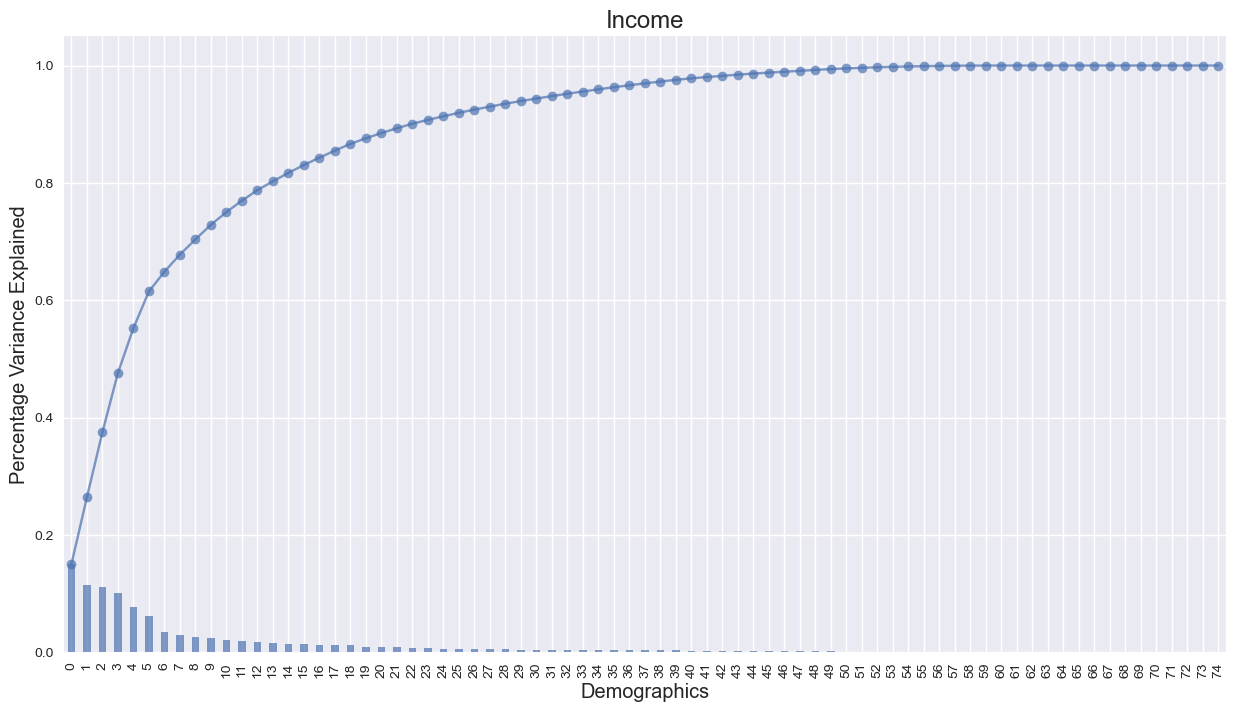

In [18]:
plt.style.use("seaborn")
plt.figure(figsize=(15,8))
exp_var = pd.Series(pca.explained_variance_ratio_)

exp_var.plot(kind="bar", alpha=0.7) # plot bar chart

# Calculate the amount of variance explained added by each additional component
total = 0
var_ls = []
for x in exp_var:
    total = total+x
    var_ls.append(total)

pd.Series(var_ls).plot(marker="o", alpha=0.7) #plot line chart of increasing variances
plt.xlabel("Demographics", fontsize="x-large")
plt.ylabel("Percentage Variance Explained", fontsize="x-large")
plt.title("Income", fontsize="xx-large")
plt.xticks(rotation = 90);
plt.show();

In [19]:
# Create a transformer for numeric columns

numeric_transformer = Pipeline(
    steps=[
        ('imputer', SimpleImputer()),
        ('scaler', StandardScaler())
    ]
)

# Create Transformer for categorical data

categorical_transformer = Pipeline(
    steps=[
        ('cat_imputer', SimpleImputer(strategy="most_frequent")),
        ('one_hot', OneHotEncoder(handle_unknown='ignore', sparse = False)) # Ignore unseen categorical in transform step not seen in fit_transform
    ]
)

# Create a preprocessor transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_selector),
        ('cat', categorical_transformer, cat_selector)
    ]
)

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('pca', PCA()),
                      ('classifier', LogisticRegression()),
                      ])

#clf.fit(X_train, y_train)

#print(f"model score: {clf.score(X_test, y_test)}")

In [20]:
# Create param grid to hyper parameter tune the model
param_grid = {
    "preprocessor__num__imputer__strategy": ["mean", "median", "most_frequent"], # adjust the strategy for imputation
    "classifier__C": [0.1, 0.3, 0.5, 0.6, 0.8, 1.0], # Adjust regularization strength
    "pca__n_components": [9, 10, 11, 12, 13, 14, 15]
}

grid = GridSearchCV(clf, # Model
                    param_grid=param_grid, # Parameters to tune
                    cv=5, # Cross Validation
                    verbose=1, # Shows output while training 
                    n_jobs=-1, # How many core to use on your computer (-1 means use all cores)
                    scoring="accuracy"
                   )

grid.fit(X_train,y_train)

Fitting 5 folds for each of 126 candidates, totalling 630 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x000001E6BC3DAA30>),
                                                                        ('cat',
                                                                         Pipeline(steps=[('cat_imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('one_hot',
                                                                                          O...
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x000001E6BC3DAEE0>)])),
                                       ('pca', PCA()),
                                       ('classifier', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'classifier__C': [0.1, 0.3, 0.5, 0.6, 0.8, 1.0],
                         'pca__n_components': [9, 10, 11, 12, 13, 14, 15],
                         'preprocessor__num__imputer__strategy': ['mean',
                                                                  'median',
                                                                  'most_frequent']},
             scoring='accuracy', verbose=1)

In [21]:
# get best parameter
grid.best_params_

{'classifier__C': 0.6,
 'pca__n_components': 15,
 'preprocessor__num__imputer__strategy': 'most_frequent'}

In [22]:
# See results
preds = grid.best_estimator_.predict(X_test)

print(classification_report(y_test,preds))

              precision    recall  f1-score   support

       <=50K       0.87      0.93      0.90      8638
        >50K       0.73      0.57      0.64      2853

    accuracy                           0.84     11491
   macro avg       0.80      0.75      0.77     11491
weighted avg       0.83      0.84      0.83     11491



## Baseline Model

In [23]:
#Create a DummyClassifier model using the 'most_frequent' strategy
dummy = DummyClassifier(strategy='most_frequent')
#Fit model on the training data and save prediction on the test sets
dummy.fit(X_train, y_train)
dummy_train_preds = dummy.predict(X_train)
dummy_test_preds = dummy.predict(X_test)

C:\Users\Elizabeth Spreng\anaconda3\envs\dojo-env\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Elizabeth Spreng\anaconda3\envs\dojo-env\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Elizabeth Spreng\anaconda3\envs\dojo-env\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

              precision    recall  f1-score   support

       <=50K       0.75      1.00      0.86     25912
        >50K       0.00      0.00      0.00      8561

    accuracy                           0.75     34473
   macro avg       0.38      0.50      0.43     34473
weighted avg       0.56      0.75      0.65     34473



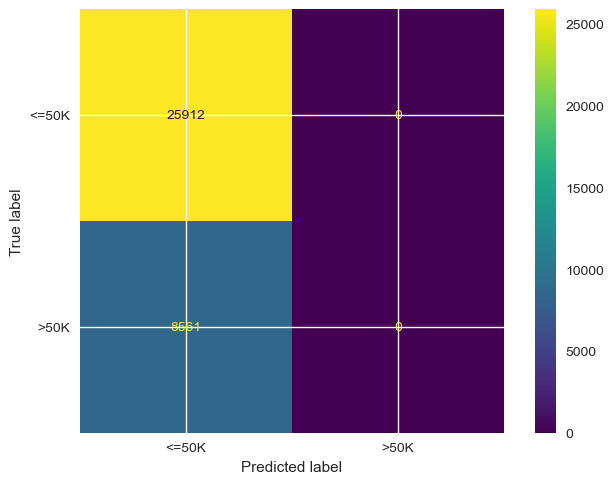

In [24]:
# Evaluate the dummy classifier on the training data using 
# classification report and a confusion matrix
ConfusionMatrixDisplay.from_predictions(y_train, dummy_train_preds);
print(classification_report(y_train, dummy_train_preds))

## Logistic Regression with PCA


In [25]:

## Create an instance of the model
log_reg = LogisticRegression()
## Create a model pipeline
log_reg_pipe = make_pipeline(preprocessor, PCA(n_components=.95), log_reg)
## Fit the model
log_reg_pipe.fit(X_train, y_train)
print(log_reg_pipe.score(X_train, y_train))
print(log_reg_pipe.score(X_test, y_test))

0.8452121950511995
0.843442694282482


## Tune the Model

In [26]:
# Remake Pipeline and let grid search tell us the best hyper parameters
pipe2 = make_pipeline(
    preprocessor,
    PCA(),
    LogisticRegression())

In [27]:
pipe2.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(transformers=[('num',
                                    Pipeline(steps=[('imputer', SimpleImputer()),
                                                    ('scaler', StandardScaler())]),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x000001E6BC3DAA30>),
                                   ('cat',
                                    Pipeline(steps=[('cat_imputer',
                                                     SimpleImputer(strategy='most_frequent')),
                                                    ('one_hot',
                                                     OneHotEncoder(handle_unknown='ignore',
                                                                   sparse=False))]),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x000001E6BC3DAEE0>)])),
  ('pca', PCA()),
  ('logisticregressio

In [28]:
# Create Grid Search CV
param_grid = {
    'logisticregression__penalty' : ['l2'], 
     'logisticregression__C': [1.0],
    'logisticregression__solver'  : ['lbfgs'],
    "logisticregression__max_iter": [100]
}

grid = GridSearchCV(
    pipe2, 
    param_grid=param_grid, 
    cv=5, 
    verbose=2,
    n_jobs=-1
)

grid.fit(X_train,y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\Elizabeth Spreng\anaconda3\envs\dojo-env\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x000001E6BC3DAA30>),
                                                                        ('cat',
                                                                         Pipeline(steps=[('cat_imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('one_h...
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                                                                        sparse=False))]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x000001E6BC3DAEE0>)])),
                                       ('pca', PCA()),
                                       ('logisticregression',
                                        LogisticRegression())]),
             n_jobs=-1,
             param_grid={'logisticregression__C': [1.0],
                         'logisticregression__max_iter': [100],
                         'logisticregression__penalty': ['l2'],
                         'logisticregression__solver': ['lbfgs']},
             verbose=2)

{0.0001: 0.7517187364024018,
 0.001: 0.7868766861021669,
 0.01: 0.8406579061874511,
 0.1: 0.8464015316334522,
 1: 0.8453572360978157,
 10: 0.8454442607257854,
 100: 0.8454442607257854,
 1000: 0.8453572360978157}

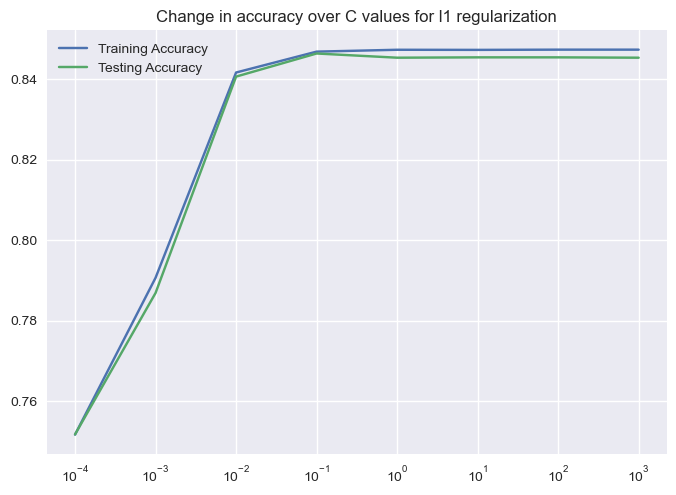

In [29]:
# create a list of c values and empty lists for scores
c_values = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
train_scores = []
test_scores = []
#iterative over the c values
for c in c_values:
 
  # instantiate a model with each value of c and fit it on the data
  log_reg = LogisticRegression(C=c, max_iter=1000, solver='liblinear', penalty='l1')
  log_reg_pipe = make_pipeline(preprocessor, log_reg)
  log_reg_pipe.fit(X_train, y_train)
 
  # add the training and testing scores to our scores lists
  train_scores.append(log_reg_pipe.score(X_train, y_train))
  test_scores.append(log_reg_pipe.score(X_test, y_test))
 
#plot the change in accuracy as we change the value of C
fig, ax = plt.subplots(1,1)
ax.plot(c_values, train_scores, label='Training Accuracy')
ax.plot(c_values, test_scores, label='Testing Accuracy')
ax.set_xticks(c_values)
ax.set_title('Change in accuracy over C values for l1 regularization')
ax.legend()
 
#set the x axis to a logarithmic scale to show the values of C in even intervals
ax.set_xscale('log')
# print a dictionary of values of C and accuracy scores
{c:score for c, score in zip(c_values, test_scores)}

{0.0001: 0.7738229919067096,
 0.001: 0.8265599164563572,
 0.01: 0.8447480637020277,
 0.1: 0.8456183099817248,
 1: 0.8453572360978157,
 10: 0.8454442607257854,
 100: 0.8454442607257854,
 1000: 0.8454442607257854}

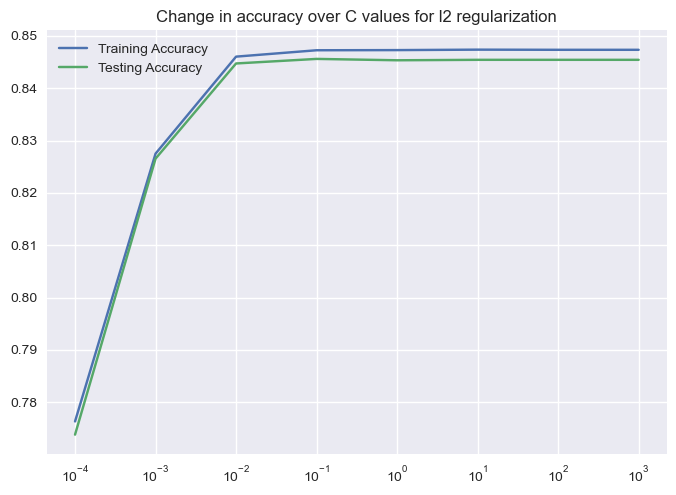

In [30]:
# create a list of c values and empty lists for scores
c_values = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
train_scores = []
test_scores = []
#iterative over the c values
for c in c_values:
  # instantiate a model with each value of c and fit it on the data
  log_reg = LogisticRegression(C=c, max_iter=1000, solver='liblinear', penalty='l2')
  log_reg_pipe = make_pipeline(preprocessor, log_reg)
  log_reg_pipe.fit(X_train, y_train)
 
  # add the training and testing scores to our scores lists
  train_scores.append(log_reg_pipe.score(X_train, y_train))
  test_scores.append(log_reg_pipe.score(X_test, y_test))
  
#plot the change in accuracy as we change the value of C
fig, ax = plt.subplots(1,1)
ax.plot(c_values, train_scores, label='Training Accuracy')
ax.plot(c_values, test_scores, label='Testing Accuracy')
ax.set_xticks(c_values)
ax.set_title('Change in accuracy over C values for l2 regularization')
ax.legend()
#set the x axis to a logarithmic scale to show the values of C in even intervals
ax.set_xscale('log')
# print a dictionary of values of C and accuracy scores
{c:score for c, score in zip(c_values, test_scores)}

## Best Model

In [31]:
#create best model
log_reg = LogisticRegression(C=.1, max_iter=1000, solver='liblinear', penalty='l1')

log_reg_final_pipe = make_pipeline(preprocessor, PCA(n_components=.95), log_reg)

log_reg_final_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001E6BC3DAA30>),
                                                 ('cat',
                                                  Pipeline(steps=[('cat_imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('one_hot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001E6BC3DAEE0>)])),
                ('pca', PCA(n_components=0.95)),
                ('logisticregression',
                 LogisticRegression(C=0.1, max_iter=1000, penalty='l1',
                                    solver='liblinear'))])

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Training Data
------------------------------------------------------------
              precision    recall  f1-score   support

       <=50K       0.87      0.93      0.90     25912
        >50K       0.74      0.59      0.65      8561

    accuracy                           0.85     34473
   macro avg       0.80      0.76      0.78     34473
weighted avg       0.84      0.85      0.84     34473



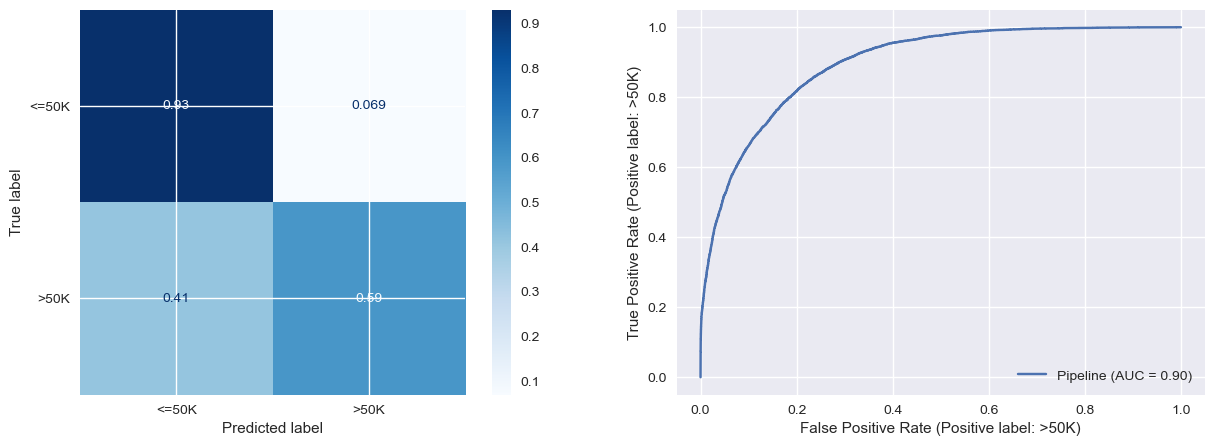

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Test Data
------------------------------------------------------------
              precision    recall  f1-score   support

       <=50K       0.87      0.93      0.90      8638
        >50K       0.73      0.59      0.65      2853

    accuracy                           0.84     11491
   macro avg       0.80      0.76      0.77     11491
weighted avg       0.84      0.84      0.84     11491



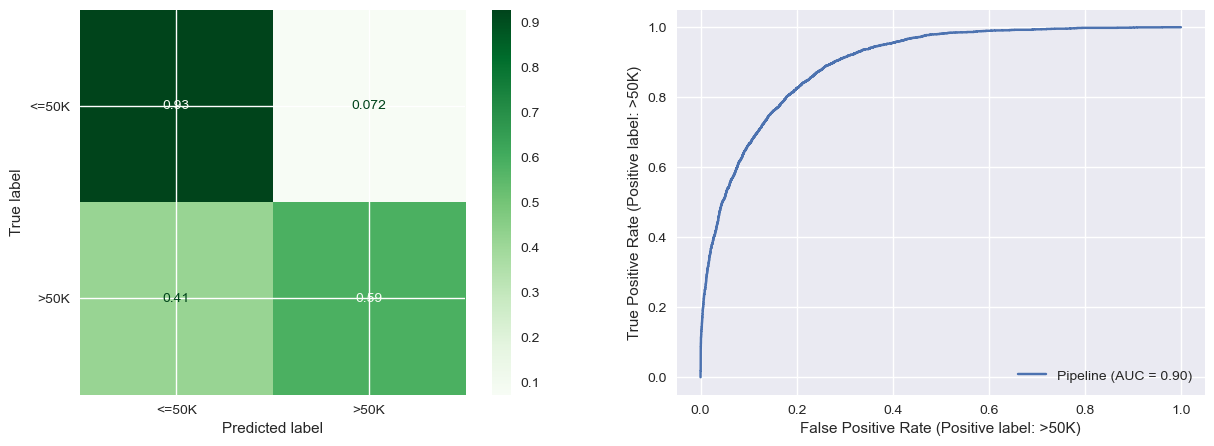

In [32]:
# print classification report

classification_metrics(log_reg_final_pipe, X_train,y_train, 
                         cmap='Blues', label='Training Data')
classification_metrics(log_reg_final_pipe, X_test,y_test, 
                         cmap='Greens',label='Test Data')



# Random Forest Model

In [33]:
## Create an instance of the model
ran_for = RandomForestClassifier(random_state=42)
## Create a model pipeline
ran_for_pipe = make_pipeline(preprocessor, PCA(n_components=.95), ran_for)
## Fit the model
ran_for_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001E6BC3DAA30>),
                                                 ('cat',
                                                  Pipeline(steps=[('cat_imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('one_hot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001E6BC3DAEE0>)])),
                ('pca', PCA(n_components=0.95)),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=42))])

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Training Data
------------------------------------------------------------
              precision    recall  f1-score   support

       <=50K       1.00      1.00      1.00     25912
        >50K       1.00      1.00      1.00      8561

    accuracy                           1.00     34473
   macro avg       1.00      1.00      1.00     34473
weighted avg       1.00      1.00      1.00     34473



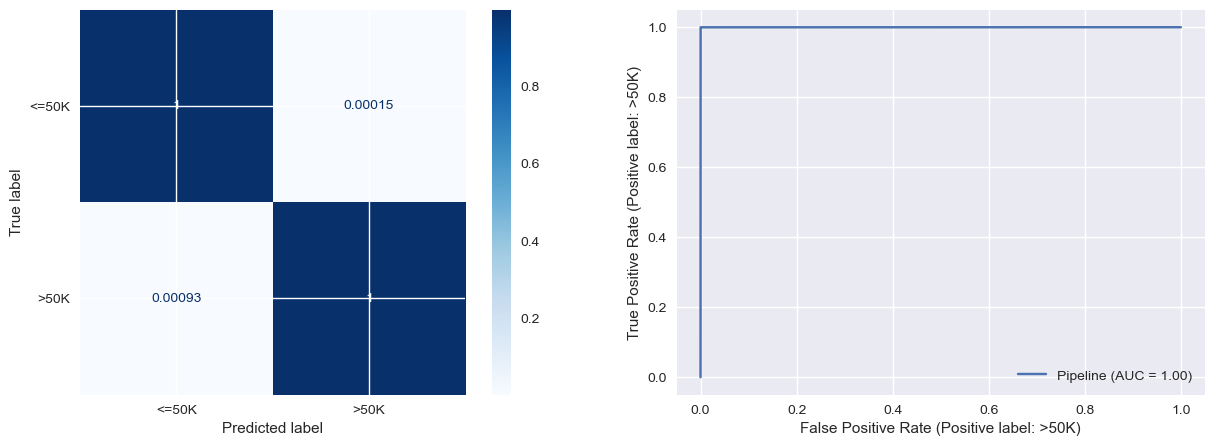

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Test Data
------------------------------------------------------------
              precision    recall  f1-score   support

       <=50K       0.88      0.92      0.90      8638
        >50K       0.71      0.61      0.66      2853

    accuracy                           0.84     11491
   macro avg       0.80      0.77      0.78     11491
weighted avg       0.84      0.84      0.84     11491



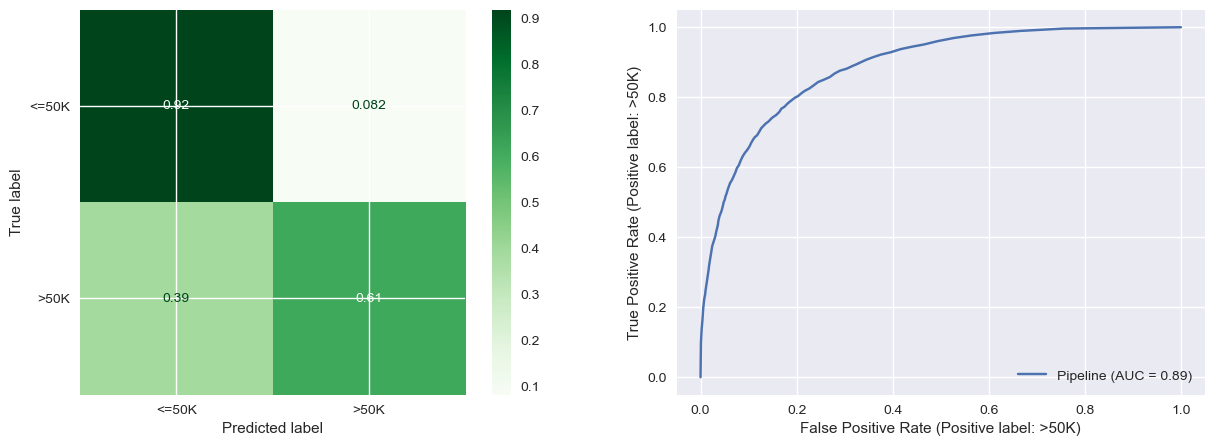

In [34]:
## Use the function twice to evaluate our model on training AND test data
classification_metrics(ran_for_pipe, X_train,y_train, 
                         cmap='Blues', label='Training Data')
classification_metrics(ran_for_pipe, X_test,y_test, 
                         cmap='Greens',label='Test Data')

## Tune the Forest

In [35]:
# Looking at some hyperparameters that seem tunable
ran_for.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [36]:
## Obtain the depths from the model using the estimators_ method
est_depths = [estimator.get_depth() for estimator in ran_for.estimators_]
## Assign the max est_depths value to max_depth variable
max_depth = max(est_depths)
## Display max_depth
max_depth

51

In [37]:
## Create a range of values from 1 to max_depth to evaluate
depths = range(1, max_depth+1)
## Create a dataframe to store Train and Test R2 scores
scores = pd.DataFrame(index=depths, columns=['Test Score'])
## Loop through the max_depth values
for depth in depths:    
   ## Create an instance of the model
   ran_for = RandomForestClassifier(max_depth=depth, random_state=42)
   ## Create a model pipeline
   ran_for_pipe = make_pipeline(preprocessor, ran_for)
   ## Fit the model
   ran_for_pipe.fit(X_train, y_train)

   ## Obtain the predictions from the model
   train_pred = ran_for_pipe.predict(X_train)
   test_pred = ran_for_pipe.predict(X_test)

   ## Obtain the accuracy scores for Train and Test
   train_accuracy = accuracy_score(y_train, train_pred)
   test_accuracy = accuracy_score(y_test, test_pred)

   ## Save the Train and Test accuracy Score for this depth in the scores dataframe
   scores.loc[depth, 'Train Score'] = train_accuracy
   scores.loc[depth, 'Test Score'] = test_accuracy

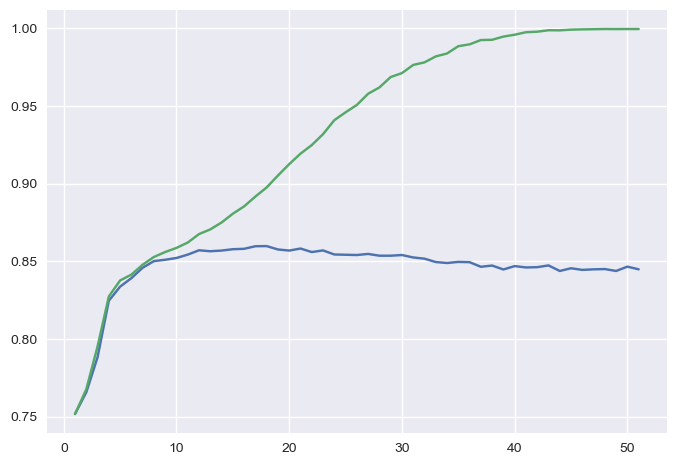

In [38]:
## Plot the scores
plt.plot(scores['Test Score'])
plt.plot(scores['Train Score'])
plt.show()

In [39]:
## Create a version on the scores dataframe
## sorted by highest Test Scores
sorted_scores = scores.sort_values(by='Test Score', ascending=False)
## Display the first (5) rows of the dataframe
sorted_scores.head()

,Test Score,Train Score
18,0.859803,0.897572
17,0.859716,0.891712
21,0.858237,0.919328
16,0.858063,0.885389
15,0.857802,0.880660


In [40]:
## sort the dataframe by test scores and save the index (k) of the best score
best_depth = sorted_scores.index[0]
## Display best_depth
best_depth

18

## Best Forest Model

In [41]:
## Create an instance of the model
ran_for = RandomForestClassifier(max_depth=best_depth, random_state=42)
## Create a model pipeline
ran_for_final_pipe = make_pipeline(preprocessor, PCA(n_components=.95), ran_for)
## Fit the model
ran_for_final_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001E6BC3DAA30>),
                                                 ('cat',
                                                  Pipeline(steps=[('cat_imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('one_hot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001E6BC3DAEE0>)])),
                ('pca', PCA(n_components=0.95)),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=18, random_state=42))])

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Training Data
------------------------------------------------------------
              precision    recall  f1-score   support

       <=50K       0.96      0.99      0.97     25912
        >50K       0.96      0.88      0.92      8561

    accuracy                           0.96     34473
   macro avg       0.96      0.93      0.95     34473
weighted avg       0.96      0.96      0.96     34473



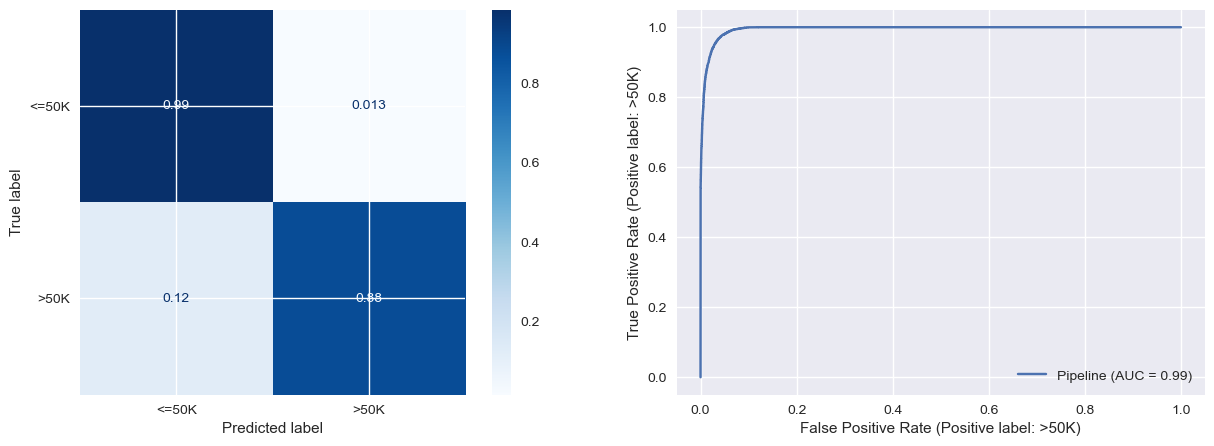

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Test Data
------------------------------------------------------------
              precision    recall  f1-score   support

       <=50K       0.88      0.93      0.90      8638
        >50K       0.74      0.61      0.67      2853

    accuracy                           0.85     11491
   macro avg       0.81      0.77      0.79     11491
weighted avg       0.84      0.85      0.85     11491



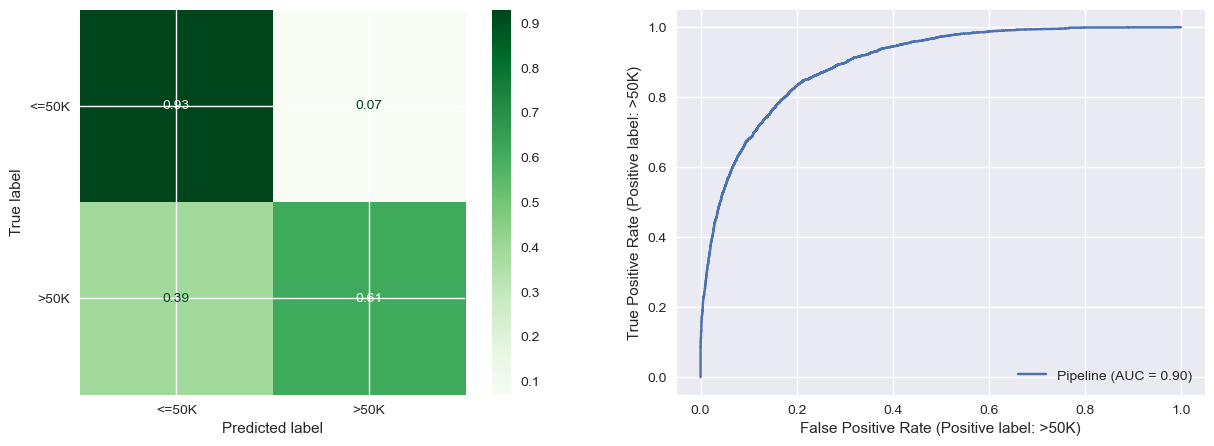

In [42]:
## Use the function twice to evaluate our model on training AND test data
classification_metrics(ran_for_final_pipe, X_train,y_train, 
                         cmap='Blues', label='Training Data')
classification_metrics(ran_for_final_pipe, X_test,y_test, 
                         cmap='Greens',label='Test Data')

# Recommendations

- Recommended Model: Random Forest Model
It has the highest accuracy score and f1-score. In this classification exercise predicting income, both false positives and false negatives were low. 